In [1]:
import numpy as np
import jax.numpy as jnp
import cvxpy as cp

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import seaborn_image as isns

import sys
sys.path.append('../')
import grid_utils as util

In [2]:
# load dataset and look at photocurrents
import glob

data_path = '../data/marta/IV_injected_sparse/preprocessed/220214_cell2_mg_A_planes.npz'
dat = np.load(data_path, allow_pickle='True')

In [3]:
def extract_multiplane_data(results, num_powers=2, grid=None):
    if grid is None:
        grid = util.load_default_grid()
        
    # take weights and firing rates from mbcs models and reshape to mean map
    # shape will be 1 x 26 x 26 x 5
    mean_mbcs = np.zeros((1, *grid.dims))
    mean_raw = np.zeros((num_powers, *grid.dims))
    mean_demixed = np.zeros((num_powers, *grid.dims))
    rfs = np.zeros((num_powers, *grid.dims))

    for i, model, psc, den_psc, I, L in zip(range(len(results['models'])), 
            results['models'], results['pscs'], results['den_pscs'], results['Is'], results['Ls']):

        raw_mean_curr, _, _, = util.make_suff_stats(psc.sum(axis=1),
            I, L)
        demixed_mean_curr, _, _ = util.make_suff_stats(
            den_psc.sum(axis=1), I, L
        )

        # extract relevant mean images
        mean_mbcs[0,:,:,i] = np.reshape(model.state['mu'], (grid.dims[0], grid.dims[1])).T
        mean_raw[:,:,:,i] = np.squeeze(raw_mean_curr, axis=-1)
        mean_demixed[:,:,:,i] = np.squeeze(demixed_mean_curr, axis=-1)
        
        # extract rfs. They are saved in the model in an array of size
        # num_neurons x num_powers, so we need to reshape
        these_rfs = model.state['rfs'].reshape(grid.dims[0], grid.dims[1], num_powers)
        these_rfs = np.swapaxes(these_rfs, 0, -1)
#         these_rfs = np.swapaxes(these_rfs, 0, 1) # equivalent of transpose along the grid dimensions
        rfs[:,:,:,i] = these_rfs
        
    return mean_raw, mean_demixed, mean_mbcs, rfs

def plot_multi_means(fig, mean_maps, depth_idxs,
                     zs=None, powers=None, map_names=None, cmaps='viridis',
                     vranges=None, cbar_labels=None):
    
    # allow option to pass separate cmaps for each grid plot
    if not isinstance(cmaps, list):
        cmaps = len(mean_maps) * [cmaps]
        
    for mean_idx, mean_map, cmap in zip(
        range(len(mean_maps)), mean_maps, cmaps):
        
        num_powers, _, _, num_planes = mean_map.shape
        num_planes_to_plot = len(depth_idxs)
        assert num_planes_to_plot <= num_planes
            
        # Create a new grid for each mean map                
        subplot_args = int("1" + str(len(mean_maps)) + str(mean_idx + 1))
        ax_curr = plt.subplot(subplot_args)
        
        if powers is not None and map_names is not None:
            ax_curr.set_title(map_names[mean_idx], y=1.08)
            
        plt.axis('off')
        
        grid = ImageGrid(fig, subplot_args,  # similar to subplot(111)
                         nrows_ncols=(num_planes_to_plot, num_powers),  # creates 2x2 grid of axes
                         axes_pad=0.05,  # pad between axes in inch.
                         cbar_mode='single',
                         cbar_pad=0.2
                         )
        if vranges is not None:
            min_val, max_val = vranges[mean_idx]
        else:
            min_val = np.nanmin(mean_map)
            max_val = np.nanmax(mean_map)
        
        for j, ax in enumerate(grid):
            row = j // num_powers
            col = j % num_powers
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_frame_on(False)

            # optionally add labels
            if zs is not None and col == 0:
                ax.set_ylabel('%d ' % zs[depth_idxs[row]] + r'$\mu m $' )

            if powers is not None and row == num_planes_to_plot - 1:
                ax.set_xlabel('%d mW' % powers[col], rotation=70)
                
            im = ax.imshow(mean_map[col,:,:,depth_idxs[row]],
                           origin='lower', vmin=min_val, vmax=max_val, cmap=cmap)

            cbar = grid[0].cax.colorbar(im)
            
        if cbar_labels is not None:
            cbar.set_label(cbar_labels[mean_idx], rotation=90, loc='top')

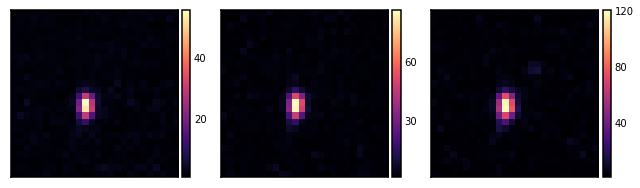

In [5]:
pscs, I, L = dat['psc'], dat['I'], dat['L']
y = pscs.sum(1)
grid_mean, _, num_stims = util.make_suff_stats(y, I, L)

img_grid = isns.ImageGrid([x.squeeze() for x in grid_mean], origin='lower', cmap='magma')

In [5]:
def sequential_map(vals):
    uniques = sorted(np.unique(vals))
    return {x: range(len(uniques))[i] for i,x in enumerate(uniques)}

def stack_observations_in_grid(y, I, L):
    num_trials = L.shape[0]
    power_levels = np.unique(I)

    xs = np.unique(L[:,0])
    ys = np.unique(L[:,1])
    zs = np.unique(L[:,2])
    
    # create arrays to store receptive fields
    x_map = sequential_map(xs)
    y_map = sequential_map(ys)
    z_map = sequential_map(zs)
    p_map = sequential_map(power_levels)
    
    obs = np.empty((len(power_levels), len(xs), len(ys), len(zs)), dtype=object)
    # initialize everything to the empty list.
    # unfortunately there's no easy way to do it.
    for pidx in range(len(power_levels)):
        for xidx in range(len(xs)):
            for yidx in range(len(ys)):
                for zidx in range(len(zs)):
                    obs[pidx, xidx, yidx, zidx] = []
            
    num_stims = np.zeros_like(obs, dtype=float)
    
    for trial in range(num_trials):
        idx = ( p_map[I[trial]],
                x_map[L[trial, 0]],
                y_map[L[trial, 1]],
                z_map[L[trial, 2]],
        )
        
        obs[idx].append(y[trial])
        num_stims[idx] += 1

    return obs, num_stims

def stack_and_min(arrays):
    stacked_arrs = np.stack(arrays, axis=0)
    return np.min(stacked_arrs, axis=0)

def stack_and_integrate(arrays):
    stacked_arrs = np.stack(arrays, axis=0)
    return np.mean(np.sum(stacked_arrs, axis=-1))

def make_roi_matrix(traces, ps, xs, ys, zs):
    ps, xs, ys, zs = np.meshgrid(ps, xs, ys, zs)
    roi_grid = traces[ps,xs,ys,zs]
    return np.array([stack_and_min(x) for x in roi_grid.ravel()])

In [6]:
grid, num_stims = stack_observations_in_grid(pscs, I, L)

In [7]:
powers = np.unique(I)
num_powers = grid.shape[0]

# Create the array we want to approximate as low-rank. This will have shape
# num_powers x num_grid_pts x time_pts
trial_min = np.array([np.array([stack_and_min(x) for x in grid[pidx,:,:,-1].ravel()])
                         for pidx in range(num_powers)])

(-0.5, 899.5, -0.5, 675.5)

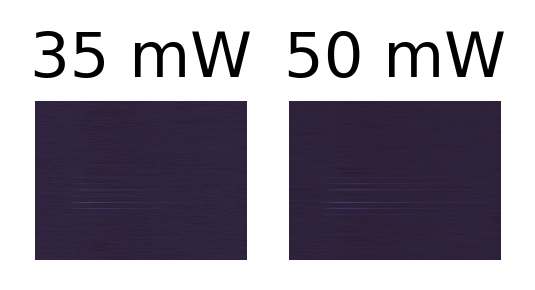

In [8]:
fig, (axs1, axs2) = plt.subplots(nrows=1, ncols=2, figsize=(2,3), dpi=300)

axs1.imshow(trial_min[0])
axs1.set_title('%d mW' % powers[0])

axs2.imshow(trial_min[1])
axs2.set_title('%d mW' % powers[1])

axs1.axis('off')
axs2.axis('off')

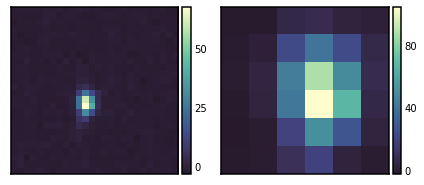

In [10]:
ps = 2
xs = np.arange(8,14)
ys = np.arange(8,14)
zs = -1

P, X, Y, Z = np.meshgrid(ps, xs, ys, zs)
roi_grid = grid[P,X,Y,Z]
roi_mat = np.array([stack_and_min(x) for x in roi_grid.ravel()])
roi_min_image = roi_mat.sum(1).reshape(len(xs), len(ys))
full_min_image = trial_min[1].sum(1).reshape(26,26)



g = isns.ImageGrid([full_min_image, roi_min_image])

In [11]:
from jaxopt import OSQP, BoxOSQP,CvxpyQP

import jax
from jax import vmap
from collections import namedtuple

Sol = namedtuple('Sol', ['primal', 'dual_eq', 'dual_ineq'])

@jax.jit
def solve_r_subproblem(G, R, Q, dual_r):
    qp = OSQP(tol=1e-6)
    def run_qp_solver(primal_init, dual_init, 
                      obj_matrix, obj_vector, ineq_matrix, ineq_vector):

        # Warm start using the current value of R for the primal variable,
        # and the value of dual_r for the dual variable
        sol = qp.run(init_params=Sol(primal_init, None, dual_init), # no equality dual vars
                      params_obj=(obj_matrix, obj_vector),
                      params_eq=None,
                      params_ineq=(ineq_matrix, ineq_vector)).params
        return sol.primal, sol.dual_ineq
    
    r_primal, r_dual = vmap(
        run_qp_solver,
        in_axes=(0, 0, None, 0, None, 0))(R, dual_r, Q @ Q.T, -G @ Q.T, Q.T, G)
    return r_primal, r_dual

@jax.jit
def solve_r_subproblem_nonneg(G, R, Q):
    qp = OSQP(tol=1e-4)
    def run_qp_solver(obj_matrix, obj_vector, ineq_matrix, ineq_vector):

        # Warm start using the current value of R for the primal variable,
        # and the value of dual_r for the dual variable
        sol = qp.run(init_params=None, # no equality dual vars
                      params_obj=(obj_matrix, obj_vector),
                      params_eq=None,
                      params_ineq=(ineq_matrix, ineq_vector)).params
        return sol.primal, sol.dual_ineq
    N, T = G.shape
    
    ineq_matrix = jnp.concatenate((Q.T, -Q.T), axis=0)
    ineq_vector = jnp.concatenate((G, jnp.zeros((N, T))), axis=1)
    r_primal, r_dual = vmap(
        run_qp_solver,
        in_axes=(None, 0, None, 0))(Q @ Q.T, -G @ Q.T, ineq_matrix, ineq_vector)
    return r_primal, r_dual

def solve_v_subproblem_nonneg2(G, U):
    qp = CvxpyQP()
    def run_qp_solver(obj_matrix, obj_vector, ineq_matrix, ineq_vector):

        # Warm start using the current value of R for the primal variable,
        # and the value of dual_r for the dual variable
        sol = qp.run(init_params=None, # no equality dual vars
                      params_obj=(obj_matrix, obj_vector),
                      params_eq=None,
                      params_ineq=(ineq_matrix, ineq_vector)).params
        return sol.primal
    N, T = G.shape
    _, K = U.shape
    
    V = np.zeros((K, T))
    for t in range(T):
        V[:,t] = run_qp_solver(
            U.T @ U,
            - U.T @ G[:,t],
            np.concatenate((U, -U), axis=0),
            np.concatenate((G[:,t], np.zeros(N)), axis=0)
        )

    return V

def solve_v_subproblem_unconstrained(G, U):
    qp = CvxpyQP()
    def run_qp_solver(obj_matrix, obj_vector):

        # Warm start using the current value of R for the primal variable,
        # and the value of dual_r for the dual variable
        sol = qp.run(init_params=None, # no equality dual vars
                      params_obj=(obj_matrix, obj_vector),
                      params_eq=None,
                      params_ineq=None).params
        return sol.primal
    N, T = G.shape
    _, K = U.shape
    
    V = np.zeros((K, T))
    for t in range(T):
        V[:,t] = run_qp_solver(
            U.T @ U,
            - U.T @ G[:,t],
        )

    return V

def lowrank_underapprox(G, R_init, Q_init, num_iters=3):
    loss_vals = np.zeros(num_iters)
    R = R_init
    Q = Q_init
    
    N, T = G.shape
    
    prev_r_dual = jnp.zeros((N, T))
    prev_q_dual = jnp.zeros((N, T))
    
    for i in range(num_iters):
        R, prev_r_dual = solve_r_subproblem(G, R, Q, prev_r_dual)
        QT, prev_q_dualT = solve_r_subproblem(G.T, Q.T, R.T, prev_q_dual.T)
        Q = QT.T
        prev_q_dual = prev_q_dualT.T
        loss_vals[i] = 0.5 * np.sum((G - R @ QT.T)**2)
        
    return loss_vals, R, QT.T

In [12]:
start_idx = 100
end_idx = 200

# scale G so it's between 0 and 1
G = np.maximum(roi_mat,0)

G_crop = G[:, start_idx:end_idx]

# Fit SVD on the section of data while the stim is on
K = 1
U, S, Vt = np.linalg.svd(G_crop)
R_init = U[:,0:K] @ np.diag(S[0:K])
Q_init = Vt[0:K,:]

from sklearn.decomposition import NMF
nmf = NMF(n_components=1)
# R_init = nmf.fit_transform(G_crop)
# Q_init = nmf.components_

# Hold R fixed, then solve for Q at each timestep
Q_constr = solve_v_subproblem_nonneg2(G, R_init)
Q_unconstr = solve_v_subproblem_unconstrained(G, R_init)

In [13]:
qp_est_unconstr = R_init @ Q_unconstr
qp_est_constr = R_init @ Q_constr

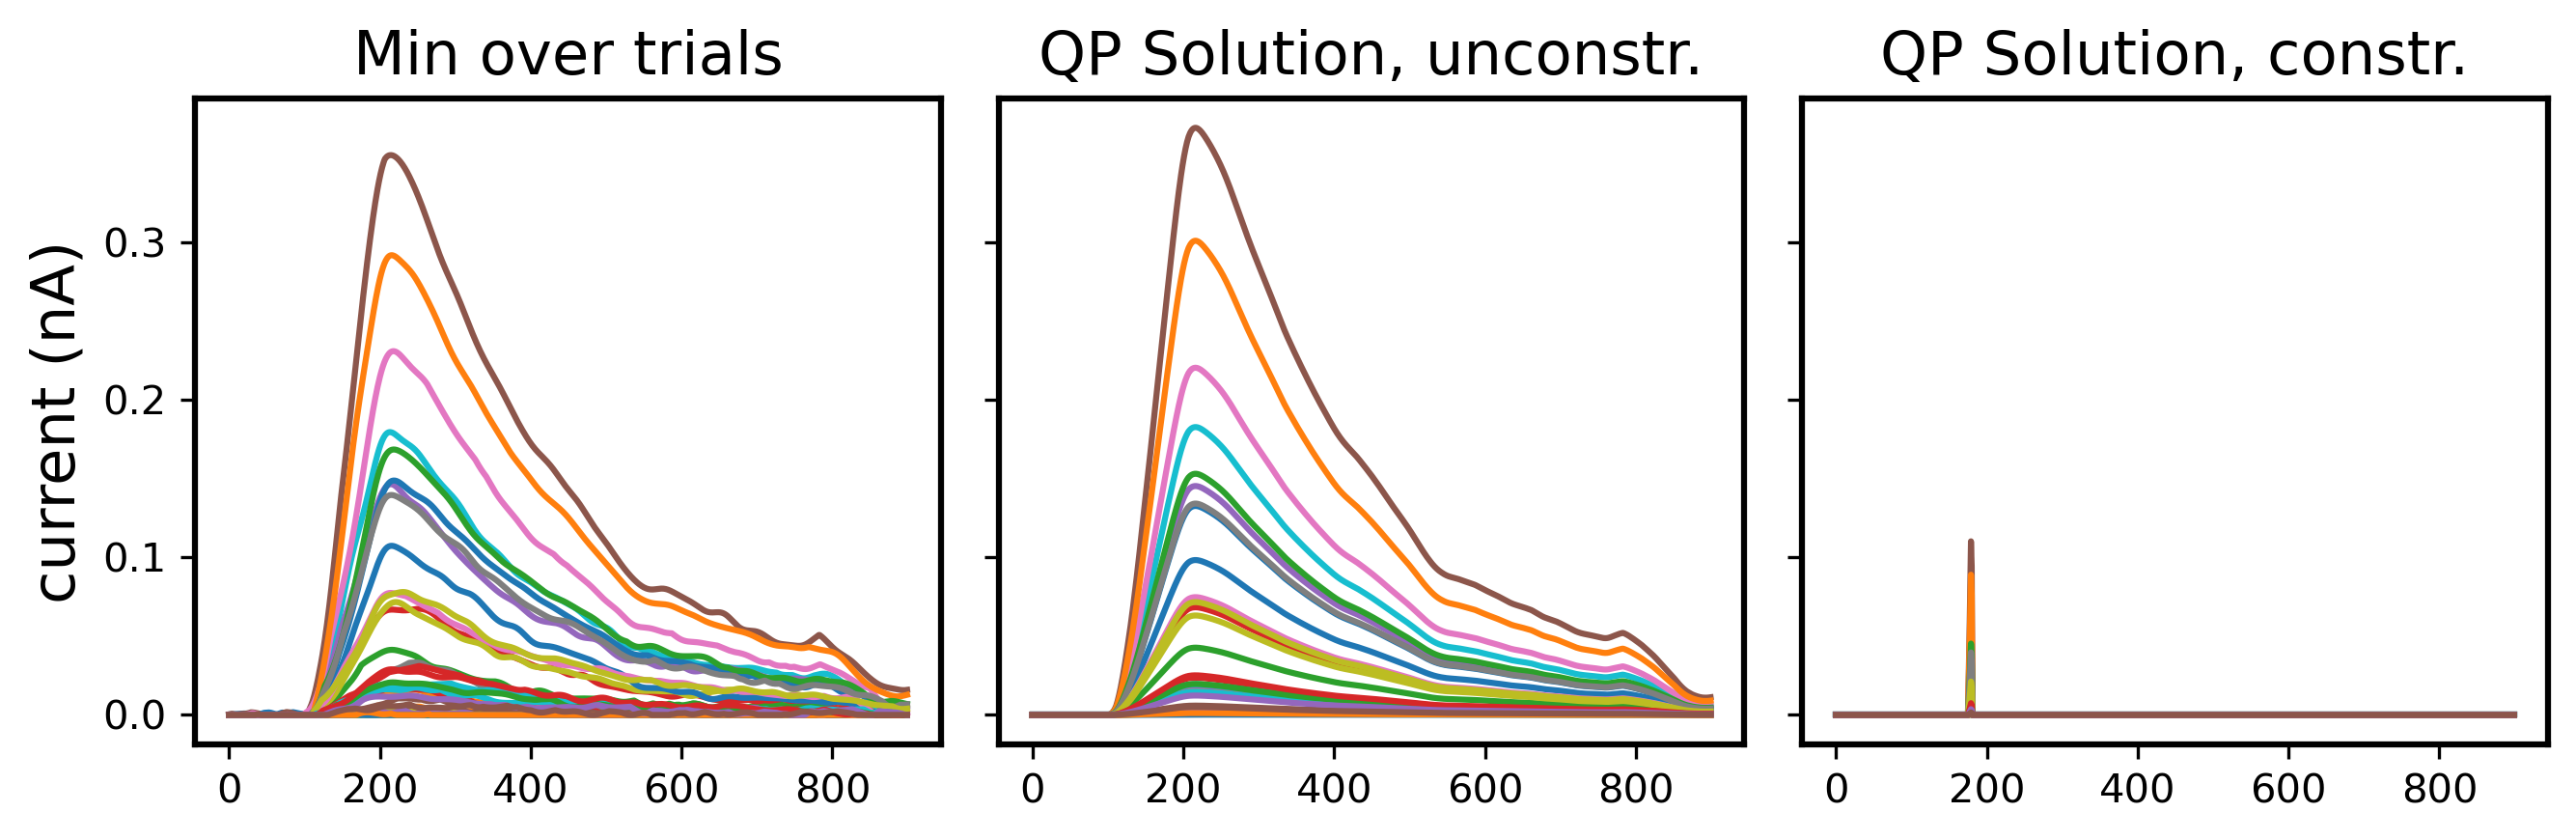

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9,3), dpi=300, sharey=True, facecolor='white')

idxs_max = np.argsort(G.sum(1))[::-1]
j = idxs_max[2:5]

ax1.plot(G.T)
ax1.set_title('Min over trials')
ax1.set_ylabel('current (nA)')

ax2.plot(qp_est_unconstr.T)
ax2.set_title('QP Solution, unconstr.')

ax3.plot(qp_est_constr.T)
ax3.set_title('QP Solution, constr.')

plt.tight_layout()

In [16]:
## Soft Under approx

# min_V sum max(0, UV - G) s.t ||UV - G|| <= noise_floor

In [17]:
np.linalg.norm(G - qp_est_unconstr, ord='fro')

0.5997310592968145

In [18]:
scale = np.max(G)
G_scaled = G / scale

G_crop_scaled = G_scaled[:, start_idx:end_idx]

# Fit SVD on the section of data while the stim is on
K = 1
U, S, Vt = np.linalg.svd(G_crop_scaled)
R_init = U[:,0:K] @ np.diag(S[0:K])
Q_init = Vt[0:K,:]



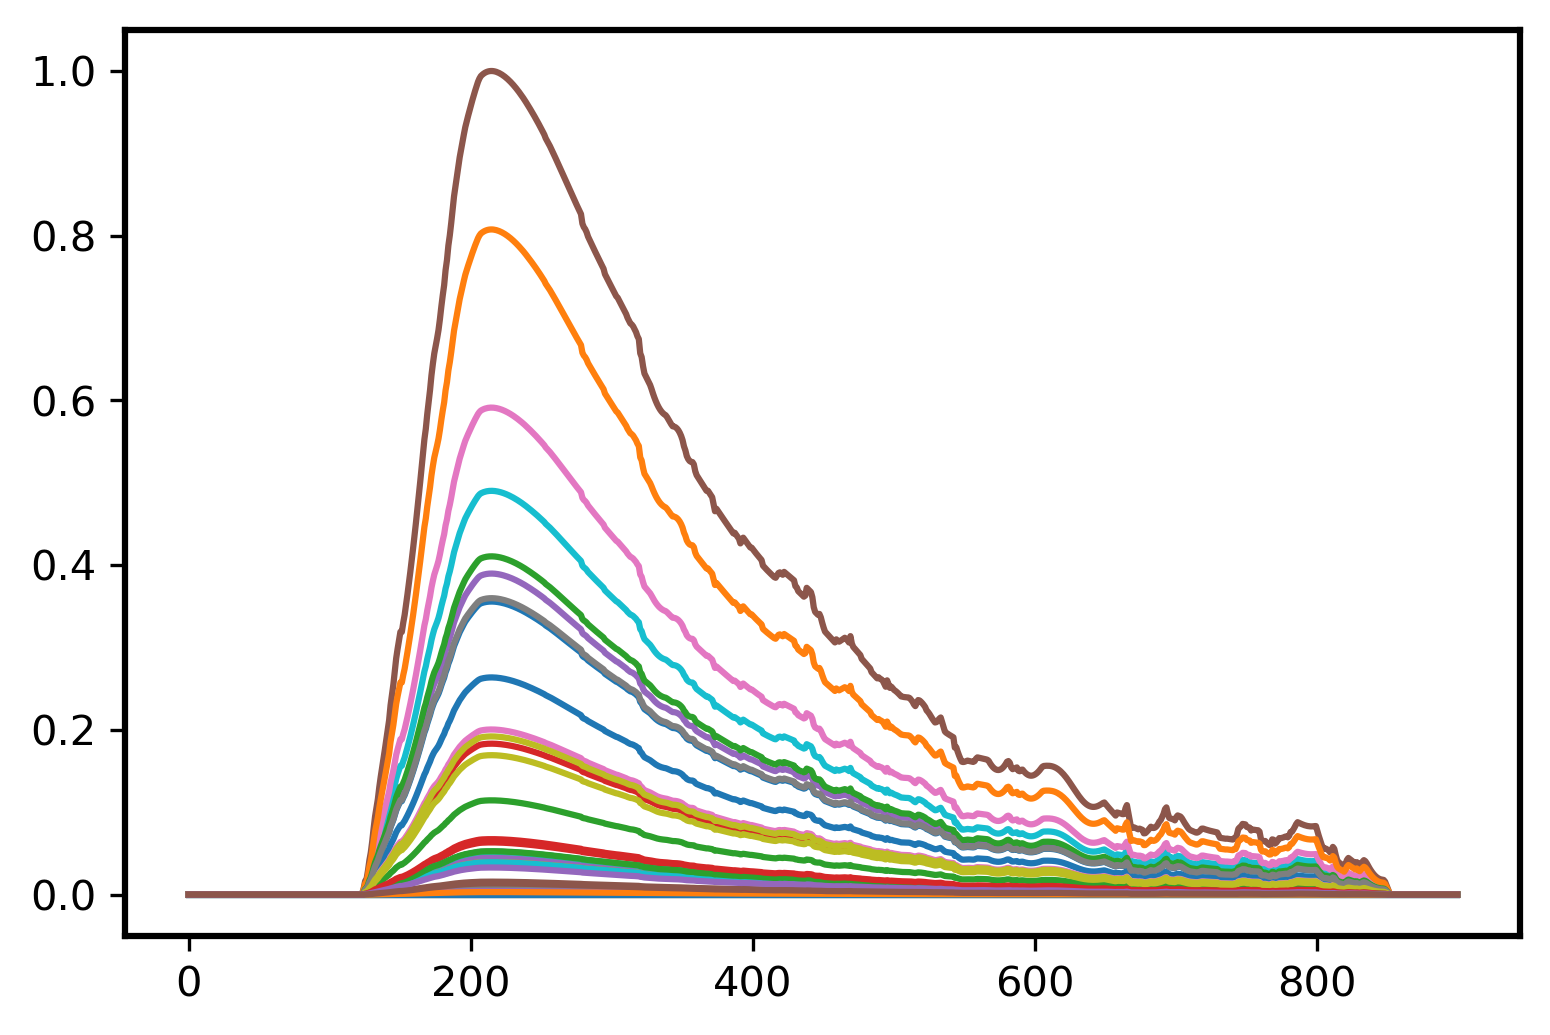

In [19]:
import cvxpy as cp

N,T = G.shape
V = cp.Variable(shape=(K,T))
sigma = 4

prob = cp.Problem(
    cp.Minimize(cp.sum(cp.maximum(0, R_init @ V - G_scaled))),
    [cp.norm(G_scaled - R_init @ V, p='fro') <= sigma]
)

prob.solve()

plt.figure(dpi=300)
soft_est = R_init @ V.value
plt.plot(soft_est.T)
plt.show()

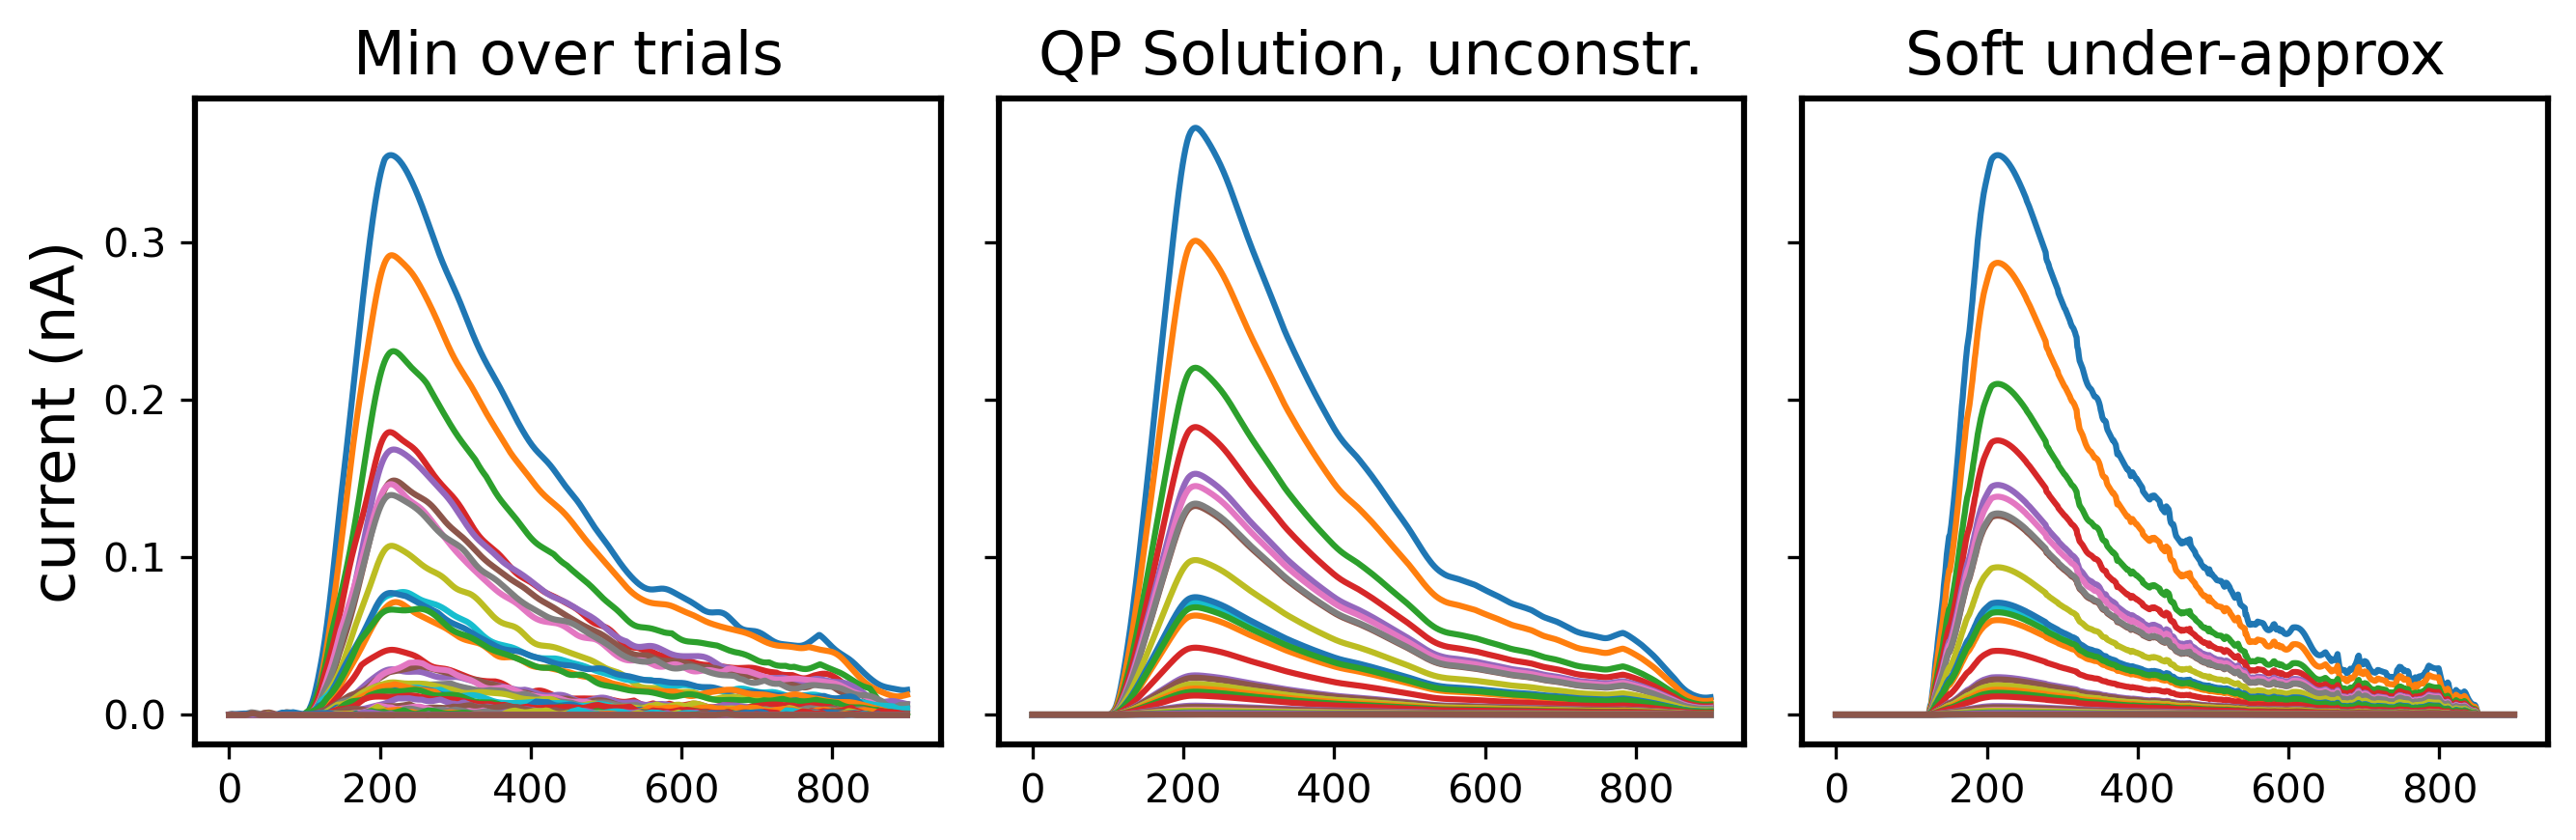

In [20]:
soft_est_rescaled = soft_est * scale

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9,3), dpi=300, sharey=True, facecolor='white')

idxs_max = np.argsort(G.sum(1))[::-1]
j = idxs_max

ax1.plot(G[j].T)
ax1.set_title('Min over trials')
ax1.set_ylabel('current (nA)')

ax2.plot(qp_est_unconstr[j].T)
ax2.set_title('QP Solution, unconstr.')

ax3.plot(soft_est_rescaled[j].T)
ax3.set_title('Soft under-approx')

plt.tight_layout()

In [21]:
# Fit low rank approx on G-scaled
# to find a lower bound on sigma
K = 1
U, S, Vt = np.linalg.svd(G_scaled)
R_init = U[:,0:K] @ np.diag(S[0:K])
Q_init = Vt[0:K,:]
np.linalg.norm(G_scaled - R_init @ Q_init, ord='fro')

1.0493421883272365

## Visualize results
show traces and grid maps after subtracting our estimated photocurrents

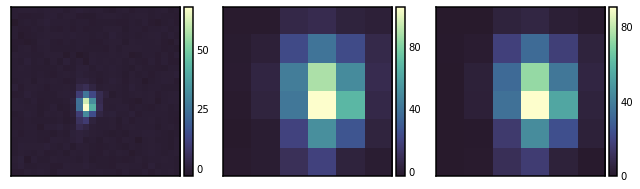

In [22]:
P, X, Y, Z = np.meshgrid(ps, xs, ys, zs)
roi_grid = grid[P,X,Y,Z]
roi_mat = np.array([stack_and_min(x) for x in roi_grid.ravel()])
roi_min_image = roi_mat.sum(1).reshape(len(xs), len(ys))
full_min_image = trial_min[1].sum(1).reshape(26,26)
est_min_image = soft_est_rescaled.sum(1).reshape(len(xs), len(ys))
g = isns.ImageGrid([full_min_image, roi_min_image, est_min_image])

In [23]:
from copy import deepcopy

# each location in the ROI containts a list of traces
roi_traces_flat = roi_grid.ravel()
roi_traces_corrected = deepcopy(roi_traces_flat)

In [24]:
def subtract_templates(roi_grid, templates):
    subtracted = 
        

SyntaxError: invalid syntax (<ipython-input-24-e828e1e37a3f>, line 2)

Text(0.5, 1.0, 'Subtracted')

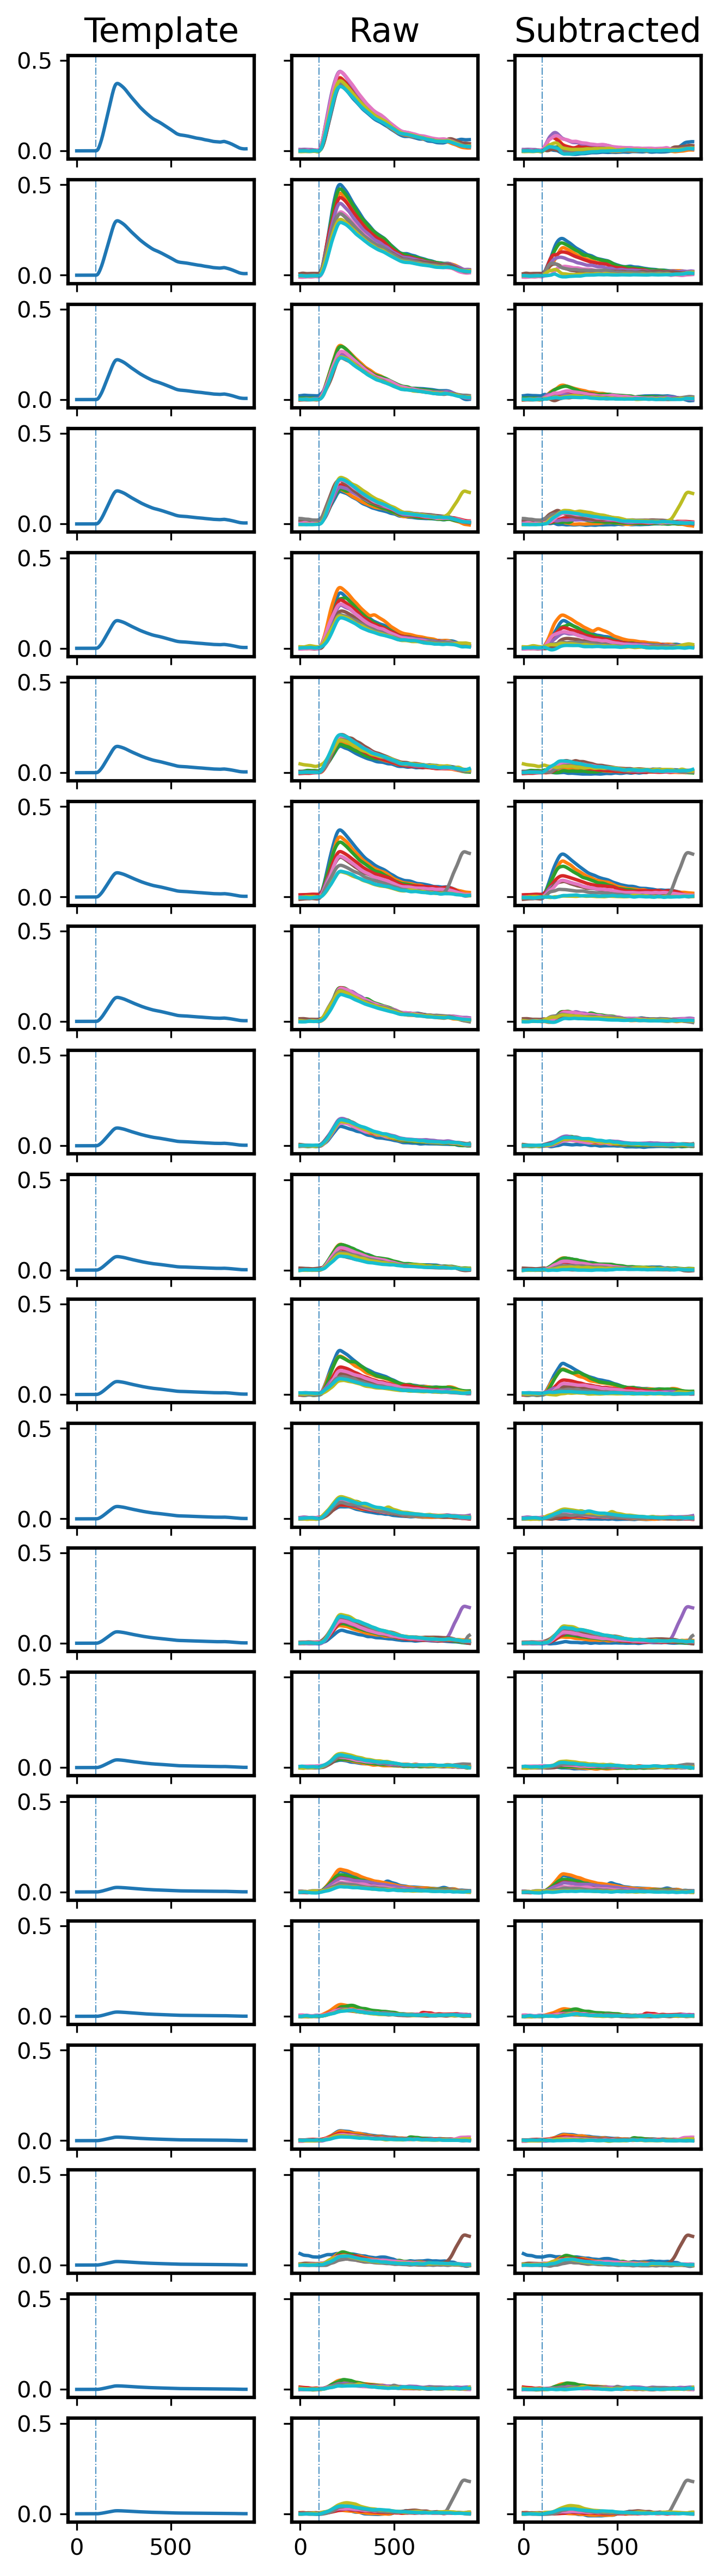

In [25]:
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                        figsize=(5,1 * num_plots), dpi=300,
                        sharey=True, sharex=True, facecolor='white')

order = np.argsort(np.sum(soft_est_rescaled, axis=-1))[::-1]

for i in range(num_plots):
    trace_idx = order[i]
    
    axs[i,0].plot(qp_est_unconstr[trace_idx])
    
    axs[i,1].plot(np.array(roi_traces_flat[trace_idx]).T)
    axs[i,2].plot((np.array(roi_traces_flat[trace_idx]) - qp_est_unconstr[trace_idx]).T)
    
    
    # plot initiation time of stim
    for j in range(3):
        plt.sca(axs[i,j])
        plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)
        
axs[0,0].set_title('Template')
axs[0,1].set_title('Raw')
axs[0,2].set_title('Subtracted')

In [7]:
## tensor decomposition

In [32]:
from tensorly.decomposition import parafac
import tensorly as tl

roi_tensor = np.array(list(roi_traces_flat))
cptensor = parafac(np.maximum(roi_tensor, 0), rank=1)
est = tl.cp_to_tensor(cptensor)

Text(0.5, 1.0, 'Subtracted')

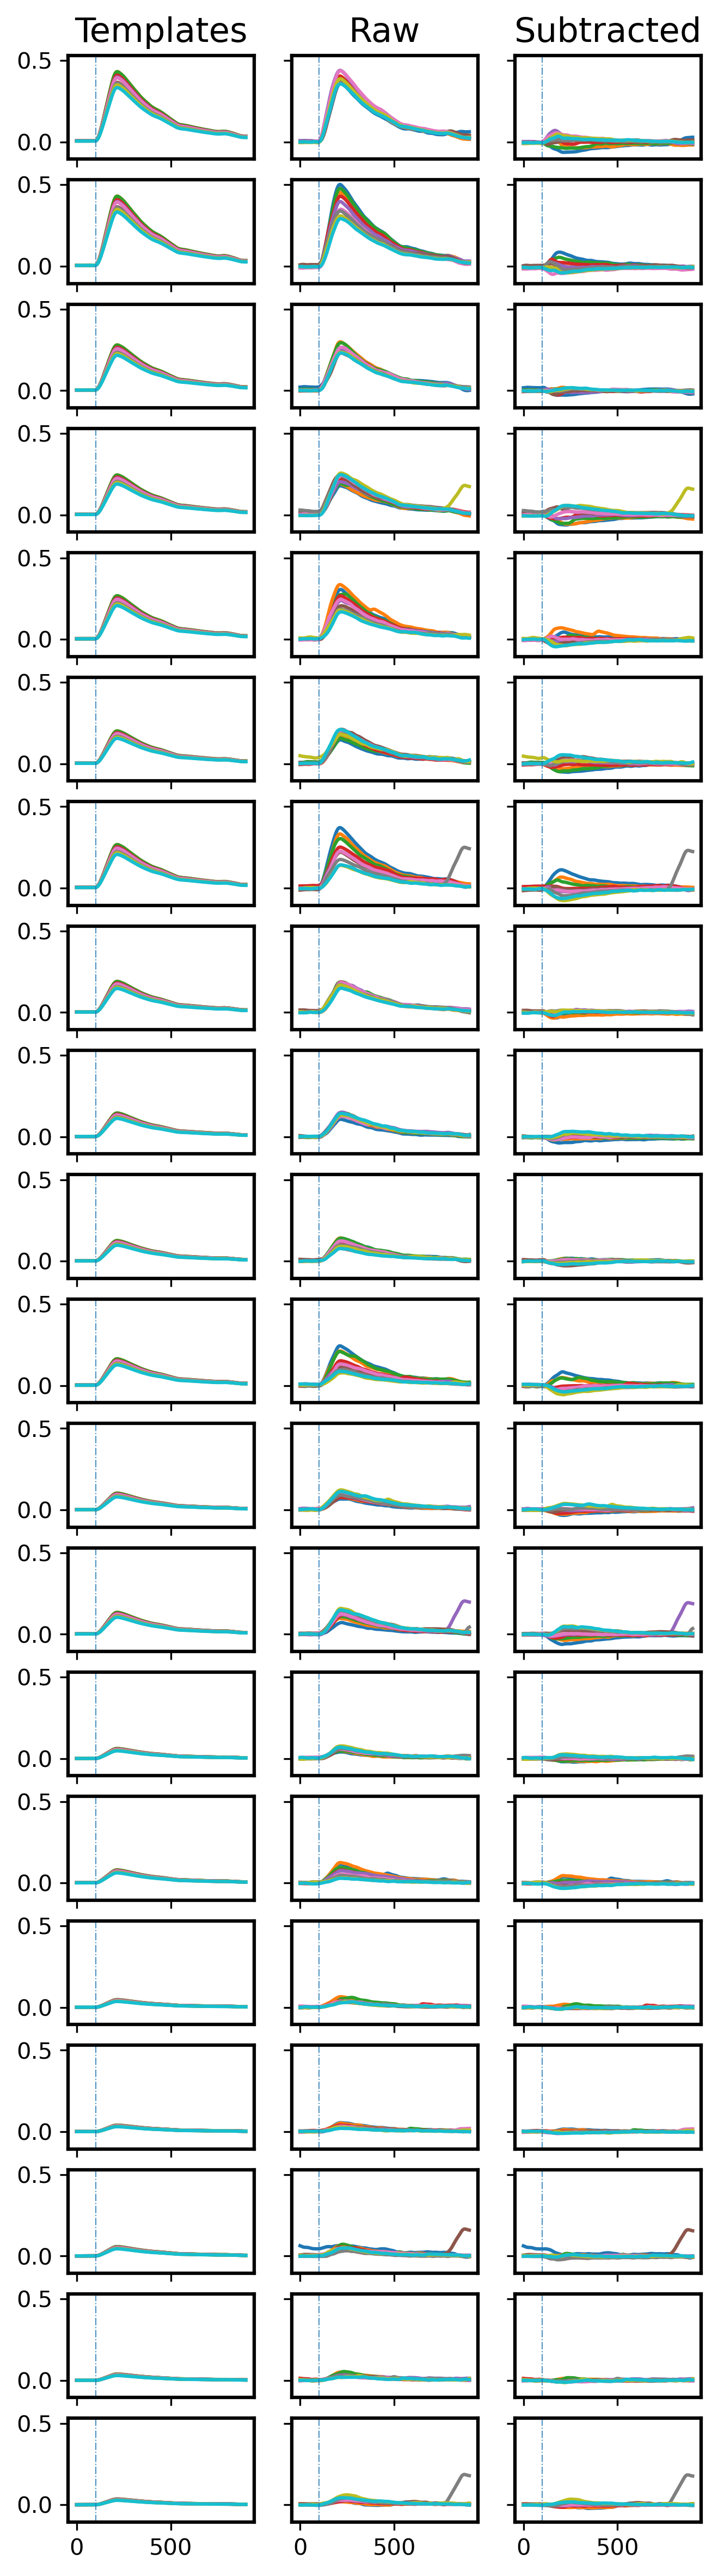

In [33]:
num_plots = 20
fig, axs = plt.subplots(nrows=num_plots, ncols=3,
                        figsize=(5,1 * num_plots), dpi=300,
                        sharey=True, sharex=True, facecolor='white')

order = np.argsort(np.sum(soft_est_rescaled, axis=-1))[::-1]

for i in range(num_plots):
    trace_idx = order[i]
    
    axs[i,0].plot(est[trace_idx].T)
    
    axs[i,1].plot(roi_tensor[trace_idx].T)
    axs[i,2].plot(roi_tensor[trace_idx].T - est[trace_idx].T)
    
    
    # plot initiation time of stim
    for j in range(3):
        plt.sca(axs[i,j])
        plt.axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)
        
axs[0,0].set_title('Templates')
axs[0,1].set_title('Raw')
axs[0,2].set_title('Subtracted')